In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [3]:
reload_recursive(helpers)

## Setup

In [35]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3
colors = helpers.get_colors()

In [5]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [6]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [7]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [8]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [9]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [10]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

## Analysis

### Pineal Volume

In [59]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'].isin(["MS", "!MS"])]
model_data = model_data.drop([1548], axis=0)
res = sm.OLS.from_formula(
    "pineal_volume ~ dz_type2 + age + tiv + Female + lesion_vol_cubic", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.038
R2_adj: 0.028
                   coef      p
Intercept         0.060  0.572
dz_type2[T.MS]   -0.090  0.437
age              -0.030  0.484
tiv               0.114  0.022
Female            0.050  0.314
lesion_vol_cubic -0.128  0.003


In [43]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("pineal_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.017
R2_adj: 0.008
                  coef      p
Intercept       -0.097  0.348
dz_type5[T.RMS]  0.073  0.539
Female           0.023  0.662
age             -0.057  0.224
tiv              0.093  0.075


See how pineal volume changes with various imaging findings

In [44]:
model_data = df_z
# model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
# model_data = df_z[df_z['dz_type5'] == "OIND"]

model_data = model_data[df_z['pineal_volume'] < 5]

outcomes = ["lesion_vol_cubic", "PRL", "thalamus", "brain", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for outcome in outcomes:
    formula = f"{outcome} ~ pineal_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[outcome] = res.pvalues['pineal_volume']
    coefs[outcome] = res.params['pineal_volume']

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
print(regression_results)

                     coef  pvals  p_fdr
lesion_vol_cubic   -0.154  0.002  0.012
PRL                 0.015  0.759  0.759
thalamus            0.102  0.018  0.043
brain               0.019  0.665  0.759
grey                0.047  0.270  0.473
white              -0.025  0.604  0.759
cortical_thickness  0.113  0.009  0.032


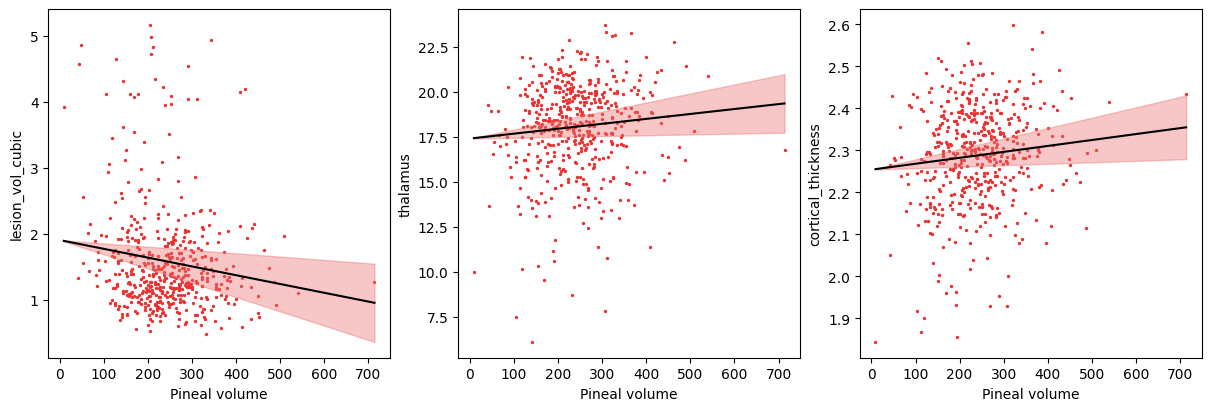

In [47]:
outcomes = ["lesion_vol_cubic", "thalamus", "cortical_thickness"]

fig, axs = plt.subplot_mosaic([outcomes], 
                               figsize=(12, 4),
                               layout='constrained',
                               )

plot_data = data.copy()
plot_data = plot_data[data_z['pineal_volume'] < 5]

dark_color = colors['dark red1']
light_color = colors['light red1']
keep_xticks = outcomes
for outcome in outcomes:
    formula = f"{outcome} ~ pineal_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=plot_data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, "pineal_volume", outcome)
    axs[outcome].scatter(plot_data['pineal_volume'], plot_data[outcome], s=2, color=dark_color)
    axs[outcome].plot(x, y_pred, color='black')
    axs[outcome].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    axs[outcome].set_ylabel(outcome)
    if outcome not in keep_xticks:
        axs[outcome].set_xlabel("")
        axs[outcome].set_xticklabels([])
    else:
        axs[outcome].set_xlabel("Pineal volume")

In [54]:
moderation_model = sm.OLS.from_formula("thalamus ~ lesion_vol_cubic*pineal_volume + tiv + age + Female", data=data_z)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.396
R2_adj: 0.389
                                 coef      p
Intercept                       0.003  0.927
lesion_vol_cubic               -0.358  0.000
pineal_volume                   0.041  0.257
lesion_vol_cubic:pineal_volume  0.021  0.540
tiv                            -0.023  0.586
age                            -0.354  0.000
Female                          0.201  0.000


Other correlations

In [75]:
model_data = df_z.copy()
# model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("pineal_volume ~ thalamus + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.017
R2_adj: 0.009
                coef      p
Intercept -2.082e-17  1.000
thalamus   1.226e-01  0.020
Female     1.498e-02  0.789
age        9.915e-03  0.846
tiv        7.484e-02  0.170


In [48]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("pineal_volume ~ EDSS + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.533
Date:                Sat, 08 Mar 2025   Prob (F-statistic):              0.192
Time:                        19:20:33   Log-Likelihood:                -2316.5
No. Observations:                 397   AIC:                             4643.
Df Residuals:                     392   BIC:                             4663.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    159.4510     67.458      2.364      0.0

In [52]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("pineal_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.475
Date:                Tue, 04 Mar 2025   Prob (F-statistic):              0.165
Time:                        14:27:24   Log-Likelihood:                -2197.7
No. Observations:                 376   AIC:                             4413.
Df Residuals:                     367   BIC:                             4449.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          167.6980     72.753  